In [41]:
%matplotlib widget

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from datetime import datetime
import os
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.time import Time
import healpy as hpy

from vasca.resource_manager import ResourceManager
from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.utils import nb_fig

In [44]:
# Load region file
region_name = "TDS"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)

In [45]:
display(rg.tt_fields)
rg.info() # Show available tables

field_id,name,ra,dec,observatory,obs_filter,sel,fov_diam,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,,deg,,s,d,d,
bytes22,bytes22,float64,float64,bytes22,bytes22,bool,float32,int32,float32,float64,float64,int32
GNU2592597978464124928,PS_XMMLSS_MOS00,35.578863351058885,-3.14176421214975,GALEX,NUV,True,1.1,27,40457.25,54791.262777777774,57213.3405928096,0
GNU2592668347208302592,PS_XMMLSS_MOS01,36.49984981667359,-3.4923125504146,GALEX,NUV,True,1.1,26,38608.996,54791.33122685185,57205.55893265336,1
GNU2592738715952480256,PS_XMMLSS_MOS02,34.995648096666685,-3.95320684099725,GALEX,NUV,True,1.1,24,23118.55,54791.399976851855,56670.07746654369,2
GNU2592809084696657920,PS_XMMLSS_MOS03,35.87152971805409,-4.25258328683038,GALEX,NUV,True,1.1,21,31699.102,54791.468136574076,57205.5459979022,3
GNU2592879453440835584,PS_XMMLSS_MOS04,36.890941423843685,-4.42319486511272,GALEX,NUV,True,1.1,23,34784.05,54791.53658564815,57214.614389105904,4
GNU2592949822185013248,PS_XMMLSS_MOS05,35.19163328261652,-5.0517494636978,GALEX,NUV,True,1.1,22,32845.8,54791.60503472222,57205.68289605035,5
...,...,...,...,...,...,...,...,...,...,...,...,...
GNU2607093939764723712,PS_GROTH_MOS02,213.77799348532596,54.3533934809404,GALEX,NUV,True,1.1,17,24084.25,54955.519328703704,57231.765437282986,36



 tt_fields:
<Table length=42>
       name        dtype  unit                       description                      
----------------- ------- ---- -------------------------------------------------------
         field_id bytes22                                          Field source ID nr.
             name bytes22                                                   Field name
               ra float64  deg                          Center RA of the field (J2000)
              dec float64  deg                         Center Dec of the field (J2000)
      observatory bytes22                    Telescope of the observation (e.g. GALEX)
       obs_filter bytes22                         Filter of the observation (e.g. NUV)
              sel    bool                        Selection of rows for VASCA analysis.
         fov_diam float32  deg Field radius or box size (depending on the observatory)
           nr_vis   int32                          Total number of visits of the field
time_bin_siz

In [46]:
# Load global GALEX visits table
with ResourceManager() as rm:
    path = rm.get_path("gal_visits_list", "sas_cloud")
    tt_gal_vis = Table.read(path)

In [47]:
# Number of visits
n_visits = rg.tt_fields["nr_vis"].sum()
# Number of fields
n_fields = len(rg.tt_fields)
# Sky area
a_sky = n_fields * 1.2 * u.deg
print(f"n_visits: {n_visits}")
print(f"n_fields: {n_fields}")
print(f"a_sky: {a_sky}")

n_visits: 1201
n_fields: 42
a_sky: 50.4 deg


In [48]:
tt_gal_vis.info

<Table length=100865>
      name        dtype 
---------------- -------
    RATileCenter float64
   DECTileCenter float64
          survey  bytes3
        nexptime float64
        fexptime float64
        imgRunID   int64
  ParentImgRunID   int64
          joinID   int64
         tileNum   int64
     specTileNum   int64
          source  bytes6
   nPhotoObjects   int64
    nPhotoVisits   int64
    PhotoObsDate bytes22
         spectra  bytes5
        nSpectra  bytes4
  nSpectraVisits  bytes4
     SpecObsDate  bytes4
        visitNum   int64
          subvis   int64
 minPhotoObsDate bytes22
 maxPhotoObsDate bytes22
  minSpecObsDate  bytes4
  maxSpecObsDate  bytes4
PhotoObsDate_MJD float64
            gall float64
            galb float64

In [49]:
rg.tt_visits.info

<Table length=1201>
     name       dtype  unit                description               
-------------- ------- ---- -----------------------------------------
        vis_id   int64                                   Visit ID nr.
time_bin_start float64    d Visit exposure start date and time in MJD
 time_bin_size float32    s                  Visit exposure time in s
           sel    bool          Selection of rows for VASCA analysis.
      rg_fd_id   int32                            Field source ID nr.

In [50]:
# Selects only visits that are in given region
sel_rg = np.isin(tt_gal_vis["imgRunID"],rg.tt_visits["vis_id"])

In [51]:
tt_rg_vis = tt_gal_vis[sel_rg]
tt_rg_vis.info

<Table length=1201>
      name        dtype 
---------------- -------
    RATileCenter float64
   DECTileCenter float64
          survey  bytes3
        nexptime float64
        fexptime float64
        imgRunID   int64
  ParentImgRunID   int64
          joinID   int64
         tileNum   int64
     specTileNum   int64
          source  bytes6
   nPhotoObjects   int64
    nPhotoVisits   int64
    PhotoObsDate bytes22
         spectra  bytes5
        nSpectra  bytes4
  nSpectraVisits  bytes4
     SpecObsDate  bytes4
        visitNum   int64
          subvis   int64
 minPhotoObsDate bytes22
 maxPhotoObsDate bytes22
  minSpecObsDate  bytes4
  maxSpecObsDate  bytes4
PhotoObsDate_MJD float64
            gall float64
            galb float64

# Observations timeline

In [52]:
# Bounds and normalization for colors
expt_min = tt_rg_vis["nexptime"].min()
expt_max = tt_rg_vis["nexptime"].max()
c_norm = Normalize(vmin=expt_min, vmax=expt_max)
c_lognorm = LogNorm(vmin=expt_min, vmax=expt_max)

print(f"Exposure times: min = {expt_min * u.s}, max = {expt_max * u.s}")

Exposure times: min = 48.0 s, max = 1706.0 s


In [53]:
tt_rg_vis["nexptime"].mean() / 60

22.43594643352761

In [54]:
rg.tt_fields["nr_vis"].mean()

28.595238095238095

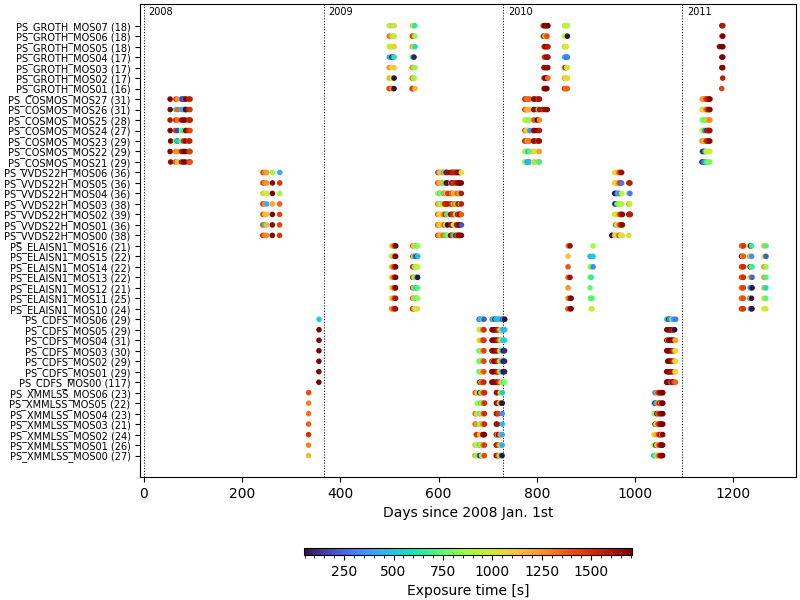

In [55]:
field_ids = np.unique(tt_rg_vis["ParentImgRunID"].data)

# Find year marks
dates = Time(tt_rg_vis["PhotoObsDate_MJD"], format="mjd").to_value(
        "datetime"
    )
years = np.unique([d.year for d in dates])

# Setup figure
fig, ax = nb_fig(num="GALEX TDS (NUV)", figsize=(8,6), constrained_layout=True)

cmap_name = "turbo"
cmap_norm = c_norm

# Loops over fields
for i, fd_id in enumerate(field_ids):
    
    # Selects only visits of given field
    sel_fd = tt_rg_vis["ParentImgRunID"] == fd_id
    tt_fd_vis = tt_rg_vis[sel_fd]

    # Single-row table with field info
    tt_fd_info = rg.tt_fields[rg.tt_fields["field_id"] == f"GNU{fd_id}"]
    fd_name = tt_fd_info['name'].data[0].decode("UTF-8")
    fd_n_vis = tt_fd_info['nr_vis'].data[0]
    
    # Reference date, Jan. 1st in year of first oservation
    mjd_ref = Time(f"{years[0]}-01-01T00:00:00.000", format="isot", scale="utc").mjd - 10
    
    # Draw visits
    y_vals = np.zeros(fd_n_vis) + i
    data_plot = ax.scatter(
        tt_fd_vis["PhotoObsDate_MJD"] - mjd_ref, y_vals,
        marker="o",
        s=3**2,
        c=cmap_norm(tt_fd_vis["nexptime"]),
        cmap=cmap_name
    )

# x-axis label
ax.set_xlabel(f"Days since {years[0]} Jan. 1st")
    
# Sets field names as y-ticks labels
ax.set_yticks(np.arange(n_fields))
ax.set_yticklabels([f"{str(row['name'])} ({row['nr_vis']})" for row in rg.tt_fields], fontsize=7)

# Draw year marks
for year in years:
    year_mark = Time(f"{str(year)}-01-01T00:00:00.000", format="isot", scale="utc").mjd - (mjd_ref + 10)
    ax.text(year_mark + 10, n_fields, f"{year}", fontsize=7)
    ax.axvline(year_mark, ls=":", lw=0.75, color="k", zorder=0)

# Color bar
cbar = fig.colorbar(
    cm.ScalarMappable(norm=cmap_norm, cmap=cmap_name),
    ax=ax,
    orientation="horizontal",
    shrink=0.5,
    aspect=45,
    label="Exposure time [s]"
)
cbar.minorticks_on()

# Sky maps

In [56]:
#Creat field table
tt_gal_vis_grp = tt_gal_vis.group_by('ParentImgRunID')
tt_gal_vis_grp_mean = tt_gal_vis_grp["gall","galb","nexptime"].groups.aggregate(np.mean)
tt_fd = Table()
tt_fd["field_id"] = np.array(list(tt_gal_vis_grp.groups.keys["ParentImgRunID"]))
grp_idx = tt_gal_vis_grp.groups.indices
tt_fd["nr_vis"] = grp_idx[1:]-grp_idx[0:-1]
tt_fd["nexptime_mean"]= tt_gal_vis_grp_mean["nexptime"]
tt_fd["gall"]= tt_gal_vis_grp_mean["gall"]
tt_fd["galb"]= tt_gal_vis_grp_mean["galb"]

In [57]:
#Select fields
sel_fd_nexptime = tt_fd["nexptime_mean"]>700
sel_fd_nr_vis = tt_fd["nr_vis"]>2
sel_fd_nr_vis_tds_9 = tt_fd["nr_vis"] >= 9
sel_fd_nr_vis_tds_16 = tt_fd["nr_vis"] >= 16
sel_fds_tds = np.isin(tt_fd["field_id"], field_ids)
#sel_fd = sel_fd_nexptime*sel_fd_nr_vis
sel_fd = sel_fds_tds
print("Selected fields have a total number of visits of:",tt_fd[sel_fd]["nr_vis"].sum())

Selected fields have a total number of visits of: 1201


In [58]:
#Setup high res plotting data
nside_hres     = 2**12
print(nside_hres)
npix_hres = hpy.nside2npix(nside_hres)
pix_diam_hres = hpy.nside2resol(nside_hres, arcmin=True) / 60 * u.deg
print("High resolution pixel diameter:",np.round(pix_diam_hres,4),"Npix:",npix_hres,"Nside:",nside_hres)
tt_fd["hvec"] = hpy.ang2vec(tt_fd["gall"],tt_fd["galb"],lonlat=True)

nr_vis_hres = np.zeros(npix_hres)  # empty map
nr_fd_hres = np.zeros(npix_hres)  # empty map
a_tds_v_vasca_hres = np.zeros(npix_hres)  # empty map
GALEX_FOV = 0.5  # disc radius in deg

# fill map with coverage data
for fd in tt_fd[sel_fds_tds]:
    ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV))
    nr_fd_hres[ipix_disc] += 1  # number of fields
    nr_vis_hres[ipix_disc] += fd["nr_vis"]

# VASCA potential coverage
for fd in tt_fd[sel_fd_nr_vis_tds_9]:
    ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV))
    a_tds_v_vasca_hres[ipix_disc] = 2.5
for fd in tt_fd[sel_fd_nr_vis_tds_16]:
    ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV))
    a_tds_v_vasca_hres[ipix_disc] = 5.5
for fd in tt_fd[sel_fds_tds]:
    ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV))
    a_tds_v_vasca_hres[ipix_disc] = 11.5

4096
High resolution pixel diameter: 0.0143 deg Npix: 201326592 Nside: 4096


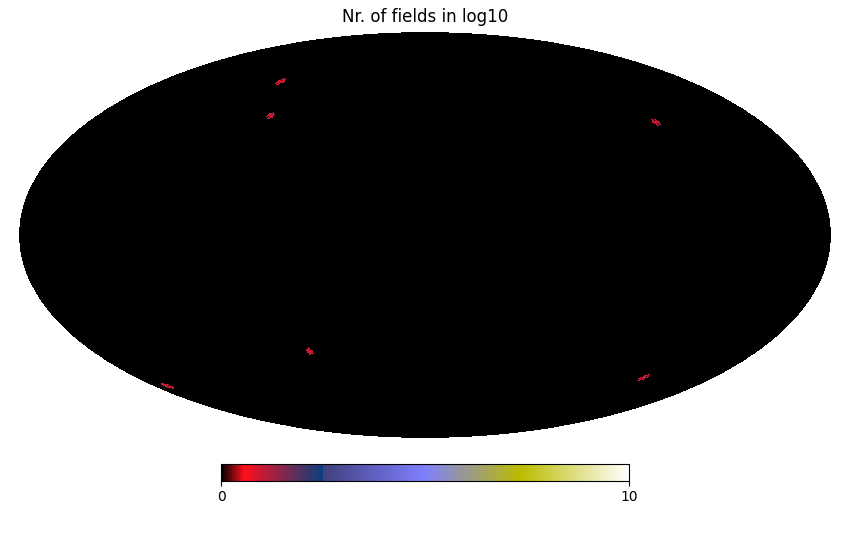

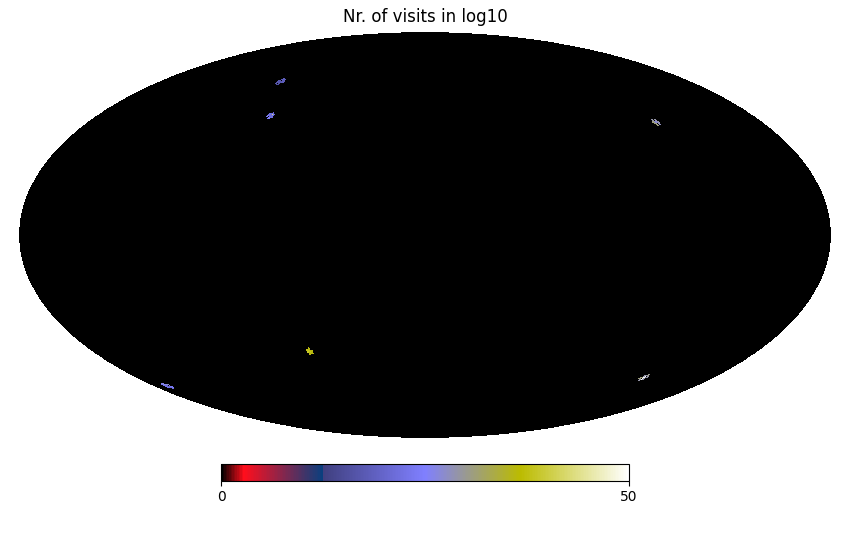

In [59]:
#Plot
cmap = "gist_stern"
#cmap = "turbo"
hpy.mollview(nr_fd_hres, title="Nr. of fields in log10",nest=False,cmap=cmap,min=0,max=10,xsize=4800)
hpy.mollview(nr_vis_hres, title="Nr. of visits in log10",nest=False,cmap=cmap,min=0,max=50, xsize=4800)

In [60]:
cm.turbo(0.2)

(0.24427, 0.60937, 0.99697, 1.0)

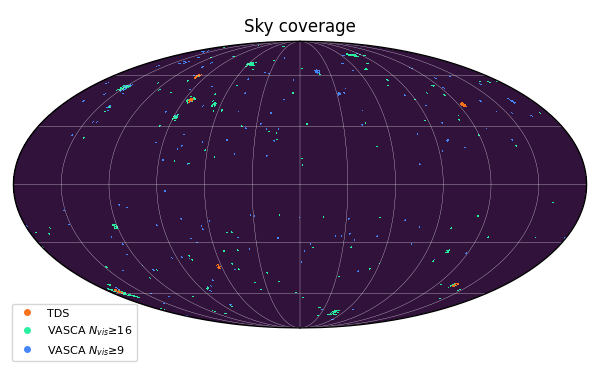

In [61]:
# setup figure
gr_size = 6
gr = (1 + 5**0.5) / 2
fig_size = (gr_size, gr_size / gr)
num = "sky cov"
plt.close(num)
fig = plt.figure(num=num, figsize=fig_size)

# colorbar
vmin = 0
vmax = 15
c_norm = Normalize(vmin=vmin, vmax=vmax)

# custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color=cm.turbo(c_norm(11.5)), ls="", label='TDS', markersize=4),
    Line2D([0], [0], marker='o', color=cm.turbo(c_norm(5.5)), ls="", label='VASCA $N_{{vis}} ≥ 16$', markersize=4),
    Line2D([0], [0], marker='o', color=cm.turbo(c_norm(2.5)), ls="", label='VASCA $N_{{vis}} ≥ 9$', markersize=4),
]



hpy.mollview(
    a_tds_v_vasca_hres,
    fig=fig,
    title="Sky coverage",
    nest=False,
    cmap="turbo",
    cbar=None,
    min=vmin,
    max=vmax,
    xsize=5000
)
hpy.graticule(color="w", lw=0.2, ls="-")
ax = plt.gca()
ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=[-0.01, -0.13], fontsize=8)

# Visit statistics

## Aggregate statistics using pandas

In [62]:
# GALEX visits info as DataFrame
df_gal_vis = tt_gal_vis.to_pandas()

# Convert survey column to proper stings
df_gal_vis["survey"] = df_gal_vis["survey"].values.astype(str)

# Sorted by survey and visit ID
df_gal_vis_grpd = df_gal_vis.groupby(["survey","ParentImgRunID"],as_index=True)

In [63]:
# Access single group
df_gal_vis_grpd.get_group(("DIS", 2592597978464124928))

,RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,...,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb
9904,35.605017,-3.148295,DIS,1540.20,1540.2,2592597840823844864,2592597978464124928,30700,8150,-999,...,b'null',1,-999,b'11/21/2008 6:18:24 AM',b'11/21/2008 6:44:04 AM',b'null',b'null',54791.262778,169.070510,-57.626828
9905,35.586541,-3.154902,DIS,1589.15,0.0,2592597840857399296,2592597978464124928,54470,8150,-999,...,b'null',2,-999,b'10/26/2009 9:16:59 AM',b'10/26/2009 9:43:28 AM',b'null',b'null',55130.386794,169.052035,-57.643744
9906,35.582341,-3.134771,DIS,1524.20,0.0,2592597840890953728,2592597978464124928,35122,8150,-999,...,b'null',3,-999,b'10/28/2009 8:56:29 AM',b'10/28/2009 9:21:53 AM',b'null',b'null',55132.372558,169.021873,-57.631009
9907,35.569204,-3.142264,DIS,1441.25,0.0,2592597840924508160,2592597978464124928,79668,8150,-999,...,b'null',4,-999,b'10/30/2009 8:36:41 AM',b'10/30/2009 9:00:42 AM',b'null',b'null',55134.358808,169.012074,-57.645176
9908,35.578203,-3.140756,DIS,1239.15,0.0,2592597840958062592,2592597978464124928,75338,8150,-999,...,b'null',5,-999,b'11/4/2009 8:37:49 AM',b'11/4/2009 8:58:28 AM',b'null',b'null',55139.359595,169.023136,-57.638251
9909,35.583443,-3.139959,DIS,1220.10,0.0,2592597840991617024,2592597978464124928,5541,8150,-999,...,b'null',6,-999,b'11/6/2009 8:18:07 AM',b'11/6/2009 8:38:27 AM',b'null',b'null',55141.345914,169.029673,-57.634279
9910,35.584711,-3.137523,DIS,1405.05,0.0,2592597841025171456,2592597978464124928,17196,8150,-999,...,b'null',7,-999,b'11/8/2009 7:57:48 AM',b'11/8/2009 8:21:13 AM',b'null',b'null',55143.331806,169.028564,-57.631599
9911,35.585481,-3.143316,DIS,1473.25,0.0,2592597841058725888,2592597978464124928,44632,8150,-999,...,b'null',8,-999,b'11/10/2009 7:36:55 AM',b'11/10/2009 8:01:28 AM',b'null',b'null',55145.317303,169.036615,-57.635546
9912,35.562476,-3.131809,DIS,1537.45,0.0,2592597841092280320,2592597978464124928,28137,8150,-999,...,b'null',9,-999,b'11/12/2009 7:15:40 AM',b'11/12/2009 7:41:17 AM',b'null',b'null',55147.302546,168.989910,-57.641471
9913,35.582675,-3.145561,DIS,1616.00,0.0,2592597841125834752,2592597978464124928,75927,8150,-999,...,b'null',10,-999,b'11/14/2009 6:54:16 AM',b'11/14/2009 7:21:12 AM',b'null',b'null',55149.287685,169.035296,-57.639066


In [64]:
# Compute aggregate statistics
df_gal_vis_agg = df_gal_vis_grpd.agg(
    {
        "ParentImgRunID": len,
        "nexptime": [np.sum, np.mean, np.std],
    }
)

# Flatten hierarchical multi-level columns and rename in-place
column_names = [
    "n_visits",
    "nexptime_sum",
    "nexptime_mean",
    "nexptime_std",
]
df_gal_vis_agg.columns = [column_names[i] for i,a in enumerate(df_gal_vis_agg.columns.to_flat_index())]

# Convert back to astropy table and add units
tt_gal_vis_agg = Table.from_pandas(df_gal_vis_agg.reset_index())
tt_gal_vis_agg["nexptime_sum"].unit = u.s
tt_gal_vis_agg["nexptime_mean"].unit = u.s
tt_gal_vis_agg["nexptime_std"].unit = u.s

In [65]:
display(df_gal_vis_agg)

n_visits  nexptime_sum  nexptime_mean  \
survey ParentImgRunID                                               
AIS    6370915756560875520         2        219.05        109.525   
       6370915757634617344         2        213.00        106.500   
       6370915758708359168         2        251.00        125.500   
       6370915759782100992         2        216.00        108.000   
       6370915760855842816         2        198.00         99.000   
...                              ...           ...            ...   
NGS    6457882727197704192         1       1627.00       1627.000   
       6457917911569793024         1        682.90        682.900   
       6457953095941881856         1       1069.05       1069.050   
       6457988280313970688         1       1674.10       1674.100   
       6458023464686059520         1        384.00        384.000   

                            nexptime_std  
survey ParentImgRunID                     
AIS    6370915756560875520      3.500179  
       6370915757634617344      2.121320  
       6370915758708359168      3.535534  
       6370915759782100992      0.000000  
       6370915760855842816      4.242641  
...                                  ...  
NGS    6457882727197704192           NaN  
       6457917911569793024           NaN  
       6457953095941881856           NaN  
       6457988280313970688           NaN  
       6458023464686059520           NaN  

[44883 rows x 4 columns]

## Compute histograms

In [66]:
# in order to control the alpha values
# of face- and edgcolor in matplotlib patches separately
# rgba touples are required
# below color codes from matplotlib color maps are listed

# rgb colors
sns_bright_rgb = [
    (0.00784313725490196, 0.24313725490196078, 1.0),
    (1.0, 0.48627450980392156, 0.0),
    (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
    (0.9098039215686274, 0.0, 0.043137254901960784),
    (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
    (0.6235294117647059, 0.2823529411764706, 0.0),
    (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
    (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
    (1.0, 0.7686274509803922, 0.0),
    (0.0, 0.8431372549019608, 1.0)
]

# rgba colors
hist_fc_alpha = 0.1
sns_bright_rgba = [(*c, hist_fc_alpha) for c in sns_bright_rgb]

### Number of visits per field

In [67]:
survey_names = np.unique(df_gal_vis["survey"]).tolist()
#survey_names.remove("CAI")  # remove clibration "survey"
survey_names_full = {
    "AIS": "All-sky Imaging Survey",
    "MIS": "Medium Imaging Survey",
    "DIS": "Deep Imaging Survey",
    "NGS": "Nearby Galaxy Survey",
    "CAI": "Calibration Imaging",
    "GII": "Guest Investigator Imaging",
}
survey_names

['AIS', 'CAI', 'DIS', 'GII', 'MIS', 'NGS']

Discovery potential with VASCA over TDS: 11.3x


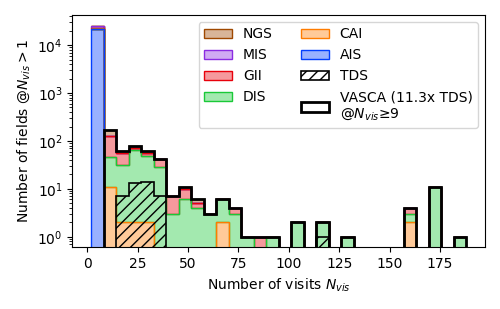

In [68]:
fig, ax = nb_fig(num="Number of visits", gr_size=5, tight_layout=True)
# Compute bins from DIS subsample
bins = np.histogram_bin_edges(df_gal_vis_agg.query("survey=='DIS' and n_visits>1")["n_visits"].values, bins="auto")

# Histogram for all DIS fields
_, _, patches_srvy = ax.hist(
    [df_gal_vis_agg.query("survey==@srvy and n_visits>1")["n_visits"].values for srvy in survey_names],
    bins=bins,
    histtype="stepfilled",
    stacked=True,
    label=survey_names,
)
for i, patch in enumerate(patches_srvy):
    patch[0].set_facecolor((*sns_bright_rgb[i], 0.4))
    patch[0].set_edgecolor(sns_bright_rgb[i])

# Compare TDS data and potential data of same quality
data_tds = rg.tt_fields["nr_vis"]  # TDS data
n_visits_tds_min = rg.tt_fields["nr_vis"].min()  # Minimum number of visits in TDS
n_visits_cut = n_visits_tds_min
n_visits_cut = 9
data_vasca = df_gal_vis_agg.query("survey in @survey_names and n_visits>=@n_visits_cut")["n_visits"]  # Potential data to be analyzed with VASCA

potential = (np.histogram(data_vasca, bins=bins)[0].sum() / np.histogram(data_tds, bins=bins)[0].sum())
print(f"Discovery potential with VASCA over TDS: {potential:1.1f}x")

# Histogram for TDS fields
counts_tds, _, _ = ax.hist(
    data_tds,
    bins=bins,
    histtype="step",
    label="TDS",
    color="k",
    hatch="///",
    lw=1.2,
)
# Histogram fields perform equally good or better
counts_vasca, _, _ = ax.hist(
    data_vasca,
    bins=bins,
    histtype="step",
    label=f"VASCA ({potential:1.1f}x TDS)\n@$N_{{vis}}≥{int(n_visits_cut)}$",
    ls="-",
    color="k",
    lw=2
)


ax.legend(ncol=2)
ax.set_xlabel("Number of visits $N_{{vis}}$")
ax.set_ylabel("Number of fields @$N_{{vis}}>1$")
ax.set_yscale("log")

### Total exposure per field

Discovery potential with VASCA over TDS: 8.5x


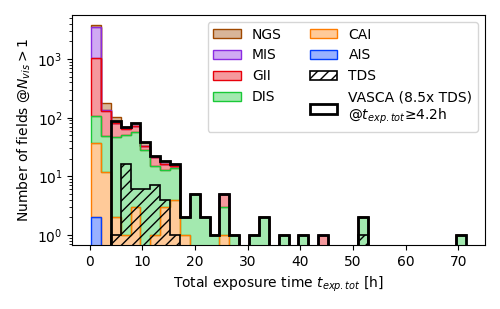

In [69]:
fig, ax = nb_fig(num="Total exposure", gr_size=5, tight_layout=True)

time_fac = 60 * 60

# Compute bins from DIS subsample
bins = np.histogram_bin_edges(df_gal_vis_agg.query("survey=='DIS' and n_visits>1")["nexptime_sum"].values / time_fac, bins="auto")

# Histogram for all DIS fields
_, _, patches_srvy = ax.hist(
    [df_gal_vis_agg.query("survey==@srvy and n_visits>1")["nexptime_sum"].values / time_fac for srvy in survey_names],
    bins=bins,
    histtype="stepfilled",
    stacked=True,
    label=survey_names,
)
for i, patch in enumerate(patches_srvy):
    patch[0].set_facecolor((*sns_bright_rgb[i], 0.4))
    patch[0].set_edgecolor(sns_bright_rgb[i])

# Compare TDS data and potential data of same quality
data_tds = rg.tt_fields["time_bin_size_sum"] / time_fac  # TDS data
nexpt_sum_tds_min = rg.tt_fields["time_bin_size_sum"].min()  # Minium total exposure in TDS
data_vasca = df_gal_vis_agg.query("survey in @survey_names and nexptime_sum>=@nexpt_sum_tds_min")["nexptime_sum"] / time_fac,  # Potential data to be analyzed with VASCA

potential = (np.histogram(data_vasca, bins=bins)[0].sum() / np.histogram(data_tds, bins=bins)[0].sum())
print(f"Discovery potential with VASCA over TDS: {potential:1.1f}x")

# Histogram for TDS fields
counts_tds, _, _ = ax.hist(
    data_tds,
    bins=bins,
    histtype="step",
    label="TDS",
    color="k",
    hatch="///",
    lw=1.2,
)
# Histogram fields perform equally good or better
counts_vasca, _, _ = ax.hist(
    data_vasca,
    bins=bins,
    histtype="step",
    label=f"VASCA ({potential:1.1f}x TDS)\n@$t_{{exp.tot}}≥{nexpt_sum_tds_min / time_fac:1.1f}$h",
    ls="-",
    color="k",
    lw=2
)




ax.legend(ncol=2)
ax.set_xlabel("Total exposure time $t_{{exp.tot}}$ [h]")
ax.set_ylabel("Number of fields @$N_{{vis}}>1$")
ax.set_yscale("log")


# Catalog comparison: GUVV, TDS, VASCA

In [70]:
# Load catalog data

# TDS
tds_catalog = "./TDS-ApJ_766_60/table4.fit"
tt_tds = Table.read(tds_catalog, hdu="J_ApJ_766_60_table4")

df_tds = tt_tds.to_pandas()
for key in ["ID", "l_mlow", "l_Dmmax", "l_sigint", "l_Sd", "l_Sy", "LC", "Mph", "OT", "X", "Class"]:
    df_tds[key] = df_tds[key].values.astype(str)

# GUVV-1
tt_guvv1 = Table.read("./GUVV-1_AJ_130_825/table2.fits")

# GUVV-2
tt_guvv2_fields = Table.read("./GUVV-2_AJ_136_259/table1.fits")
tt_guvv2 = Table.read("./GUVV-2_AJ_136_259/table2.fits")

In [71]:
tt_tds

recno,ID,RAJ2000,DEJ2000,l_mlow,mlow,l_Dmmax,Dmmax,l_sigint,sigint,l_Sd,Sd,l_Sy,Sy,LC,Mph,rmag,OT,z,X,Class
,,deg,deg,,mag,,mag,,mag,,mag,,mag,,,mag,,,,
int32,bytes16,float64,float64,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,bytes3,float32,bytes3,float32,bytes1,bytes12
1,GROTH_MOS01-21,216.1622,54.0911,,22.54,,4.60,,1.04,,0.80,,1.13,V,pt,14.92,Mdw,--,,Mdw
2,VVDS22H_MOS05-05,333.8326,-0.5491,,21.14,,4.47,,0.99,,0.90,,0.74,F,pt,21.24,QSO,--,,CV
3,ELAISN1_MOS15-02,242.0397,54.3586,>,22.89,>,4.03,,1.37,,0.84,,2.93,V,pt,22.51,QSO,--,,CV
4,ELAISN1_MOS15-09,242.3685,53.6738,>,23.03,>,4.02,,1.23,,0.01,,2.15,F,ext,21.05,,--,,Galaxy Trans
5,GROTH_MOS07-09,212.5024,52.4153,>,23.10,>,3.61,,3.51,,0.09,,0.69,F,pt,17.45,Mdw,--,,Mdw
6,CDFS_MOS02-20,53.1682,-26.3564,>,23.06,>,3.60,,0.73,,0.95,,0.78,,,15.72,Mdw,--,,Mdw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,COSMOS_MOS21-12,150.5294,3.0580,,18.07,,0.26,,0.07,<,0.00,,0.13,V,ext,13.93,,0.023,,AGN


In [72]:
df_tds

,recno,ID,RAJ2000,DEJ2000,l_mlow,mlow,l_Dmmax,Dmmax,l_sigint,sigint,...,Sd,l_Sy,Sy,LC,Mph,rmag,OT,z,X,Class
0,1,GROTH_MOS01-21,216.1622,54.0911,,22.540001,,4.60,,1.04,...,0.80,,1.13,V,pt,14.920000,Mdw,NaN,,Mdw
1,2,VVDS22H_MOS05-05,333.8326,-0.5491,,21.139999,,4.47,,0.99,...,0.90,,0.74,F,pt,21.240000,QSO,NaN,,CV
2,3,ELAISN1_MOS15-02,242.0397,54.3586,>,22.889999,>,4.03,,1.37,...,0.84,,2.93,V,pt,22.510000,QSO,NaN,,CV
3,4,ELAISN1_MOS15-09,242.3685,53.6738,>,23.030001,>,4.02,,1.23,...,0.01,,2.15,F,ext,21.049999,,NaN,,Galaxy Trans
4,5,GROTH_MOS07-09,212.5024,52.4153,>,23.100000,>,3.61,,3.51,...,0.09,,0.69,F,pt,17.450001,Mdw,NaN,,Mdw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,1074,VVDS22H_MOS05-00,333.4082,-0.7183,,18.059999,,0.26,,0.04,...,0.02,,0.10,V,pt,17.190001,QSO,1.182,,QSO
1074,1075,COSMOS_MOS23-20,150.9247,2.0944,,19.200001,,0.26,,0.05,...,0.03,,0.14,V,ext,16.770000,,NaN,,AGN
1075,1076,GROTH_MOS04-15,212.2576,53.1997,,19.790001,,0.24,,0.05,...,0.12,,0.07,V,pt,16.360001,RRL,NaN,,RRL
1076,1077,GROTH_MOS06-03,214.1765,52.3035,,18.540001,,0.24,,0.08,...,0.02,,0.23,V,pt,17.570000,QSO,1.282,X,QSO


In [73]:
tt_guvv1

GUVV,Var,USNO,OName,Type,Survey,NUVobs,NUVdet,NUVmax,NUVdm,FUVobs,FUVdet,FUVmax,FUVdm,gmag,f_gmag,rmag,f_rmag
,,,,,,,,mag,mag,,,mag,mag,mag,,mag,
bytes18,bytes1,bytes12,bytes24,bytes18,bytes3,int16,int16,float64,float64,int16,int16,float64,float64,float64,bytes1,float64,bytes1
J004347.9+421654.9,V,1322-0015866,CC And,Delta Sct variable,NGS,9,9,13.02,0.63,9,9,16.07,0.93,0.00,,0.00,
J004548.2-435509.1,V,0460-0006826,,PV,DIS,10,10,16.00,1.38,10,9,18.59,3.77,0.00,,0.00,
J010732.6+360956.5,V,1261-0017670,1RXS J010732.1+361001,x-ray source,NGS,2,2,20.01,0.60,2,2,21.47,0.55,0.00,,0.00,
J085218.1+311047.2,V,1211-0164505,,,AIS,3,3,15.00,0.33,3,3,18.77,0.37,15.23,*,15.19,*
J090054.7+303113.3,T,,,,AIS,2,1,19.69,0.00,2,1,20.92,0.00,22.44,,21.29,
J090808.2-004610.9,V,0892-0180755,,,MIS,3,3,17.99,2.47,2,2,18.56,2.88,15.40,,14.53,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J123512.5+621744.6,T,1522-0247069,,,DIS,72,1,18.61,0.00,41,1,18.98,0.00,19.59,,18.07,


In [74]:
tt_guvv2_fields

Field,Survey,Nvis,RAdeg,DEdeg
,,,deg,deg
bytes26,bytes3,int16,float64,float64
CARINA_DPH,NGS,24,100.36,-51.31
CCS_DSF2237,DIS,20,339.96,11.88
CCS_Q2233,DIS,25,339.04,13.94
CDFS_00,DIS,61,53.13,-27.87
CDFS_01,DIS,21,52.01,-28.21
CDFS_03,DIS,22,54.17,-27.31
...,...,...,...,...
XMMLSS_06,DIS,20,34.60,-3.65


In [75]:
tt_guvv2

GUVV,OName,SIMBAD,Type,Field,o_NUVmag,NUVmag,NUVamp,o_FUVmag,FUVmag,FUVamp,Bmag,f_Bmag,Rmag,f_Rmag,Imag,f_Imag
,,,,,,mag,mag,,mag,mag,mag,,mag,,mag,
bytes18,bytes19,bytes31,bytes3,bytes26,int16,float64,float64,int16,float64,float64,float64,bytes1,float64,bytes1,float64,bytes1
J001437.6-392632.2,0505-0002317,,,GI2_057001_NGC55,19,19.38,0.70,0,0.00,0.00,18.22,i,17.46,i,18.09,i
J001530.6-384855.9,0511-0002596,,,GI2_057001_NGC55,19,19.02,1.72,6,20.34,3.45,15.86,i,13.87,i,13.39,i
J001611.6-392721.5,0505-0002614,,,GI2_057001_NGC55,19,16.16,2.02,16,17.59,5.81,14.91,i,13.75,i,13.95,i
J002147.4+000031.3,J002147.52+000030.9,RX J0021.7+0000,X,WHTDF_00,24,20.18,0.67,24,20.16,1.07,19.58,,19.18,,18.28,
J002442.4+165808.0,1069-0004486,,,GI1_022001_CL0024p1654,8,17.68,0.71,1,22.79,0.00,13.62,i,13.03,i,12.67,i
J002904.4-425242.9,0471-0004614,ELAISC15 J002904-425243,QSO,ELAISS1_08,26,19.88,0.92,22,20.66,1.86,20.00,i,19.43,i,18.54,i
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J224029.0+120056.3,1020-0738869,,,CCS_DSF2237,19,17.56,0.85,19,19.69,2.70,15.73,i,14.59,i,14.37,i


In [76]:
# VASCA catalog of 5σ variable UV sources
tt_vasca = rg.tt_sources[rg.tt_sources["sel"]]
tt_vasca

fd_src_id,ra,dec,pos_err_mean,pos_err,pos_var,nr_det,nr_uls,mag_mean,mag_err_mean,mag_var,flux_cpval,flux_rchiq,mag_dmax,mag_dmax_abs,mag_dmax_sig,ul_weight,mag_sig_int2,mag_skew,sel,rg_fd_id,rg_src_id,nr_fd_srcs
,deg,deg,deg,deg,deg,,,mag,mag,mag2,,,mag,mag,,,mag,,,,,
int32,float64,float64,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int32,int32,int32
-1,334.72114723578886,0.3913897432978659,0.0001868156,2.9837034e-05,5.8081433e-08,39,0,20.045197,0.047767725,0.0068195807,1.3507839e-09,3.0129645,0.23922157,0.23922157,4.3842154,-1.0,0.004537825,0.76378846,True,-1,64,2
-1,334.60402277431285,0.407370591921308,0.00015331787,2.1656691e-05,1.6772194e-08,50,0,19.286772,0.026430907,0.001997267,1.470172e-10,2.8381653,0.09505844,0.09505844,3.6117308,-1.0,0.001298674,-0.4071733,True,-1,152,2
-1,334.37172678996603,0.14254577202050694,0.00015080985,1.8526962e-05,3.770783e-08,66,0,18.495455,0.016990429,0.0010651371,1.0106323e-21,3.6768827,0.08370972,0.08370972,5.7376924,-1.0,0.00077646243,0.76316464,True,-1,366,2
-1,334.33170174345287,-0.5332450635999029,0.00021216142,3.5940262e-05,4.4736726e-08,34,0,22.02336,0.16985331,0.092994355,1.520936e-07,2.8023326,0.45415688,0.8100014,4.1725416,-1.0,0.06414421,0.95011145,True,-1,406,2
-1,334.16724395647196,0.27227869502152147,0.0001776194,4.0678453e-05,2.2336675e-08,19,0,20.137081,0.045907248,0.011777934,6.696911e-13,5.4094806,0.22941017,0.22941017,5.4233475,-1.0,0.009670459,-0.4820578,True,-1,537,2
-1,334.0939366803409,-0.2946746400276805,0.00015795308,2.8289147e-05,1.1802242e-08,31,0,19.654408,0.03351985,0.0077170427,6.312471e-20,5.378053,0.42400932,0.42400932,13.065392,-1.0,0.0065934625,-3.8784149,True,-1,623,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,34.733199269907125,-4.201129666237845,0.0002148006,4.350191e-05,6.1529846e-08,23,0,22.159033,0.17767979,0.1646112,8.173107e-14,5.033182,0.5281162,0.62389183,4.9174986,-1.0,0.1330411,0.48574945,True,-1,221590,1


## Maximum variabiltiy amplitude

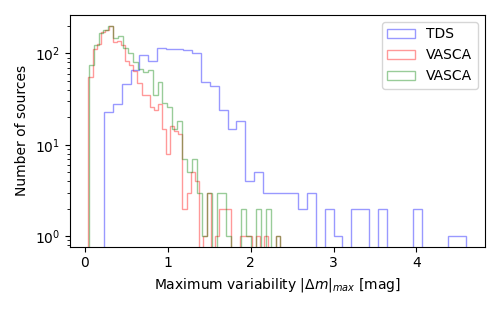

In [77]:
fig, ax = nb_fig(num="dmag_max", gr_size=5, tight_layout=True)

bins = np.histogram_bin_edges(tt_vasca["mag_dmax"], bins="auto")
#bins = np.histogram_bin_edges(tt_tds["Dmmax"], bins="auto")

ax.hist(
    tt_tds["Dmmax"],
    bins="auto",
    histtype="step",
    alpha=0.4,
    facecolor="b",
    edgecolor="b",
    label="TDS",
)
ax.hist(
    tt_vasca["mag_dmax"],
    bins="auto",
    histtype="step",
    alpha=0.4,
    facecolor="r",
    edgecolor="r",
    label="VASCA",
)
ax.hist(
    tt_vasca["mag_dmax_abs"],
    bins="auto",
    histtype="step",
    alpha=0.4,
    facecolor="g",
    edgecolor="g",
    label="VASCA",
)

ax.set_yscale("log")
ax.set_xlabel("Maximum variability $|\\Delta m|_{{max}}$ [mag]")
ax.set_ylabel("Number of sources")
ax.legend()

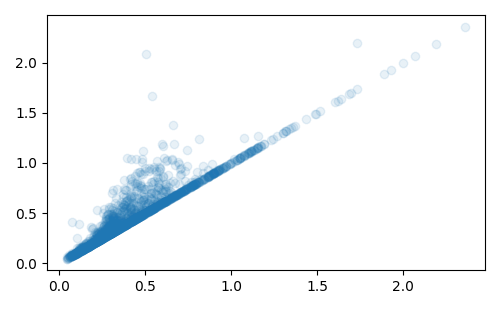

In [78]:
fig, ax = nb_fig(num="abs_v_sig", gr_size=5, tight_layout=True)

ax.scatter(tt_vasca["mag_dmax"], tt_vasca["mag_dmax_abs"], alpha=.1)

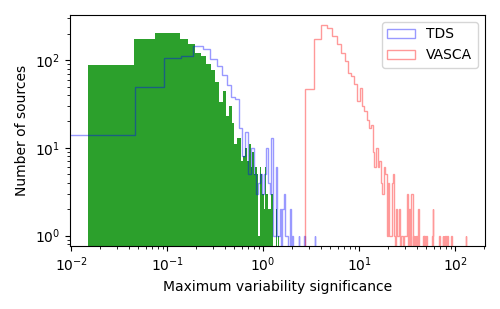

In [79]:
fig, ax = nb_fig(num="mag_dmax_sig", gr_size=5, tight_layout=True)

bins = np.histogram_bin_edges(tt_vasca["mag_dmax_sig"], bins="auto")
#bins = np.histogram_bin_edges(tt_tds["Dmmax"], bins="auto")

ax.hist(
    tt_tds["sigint"],
    bins="auto",
    histtype="step",
    alpha=0.4,
    facecolor="b",
    edgecolor="b",
    label="TDS",
)
ax.hist(
    tt_vasca["mag_dmax_sig"],
    bins="auto",
    histtype="step",
    alpha=0.4,
    facecolor="r",
    edgecolor="r",
    label="VASCA",
)

ax.hist(
    np.sqrt(tt_vasca["mag_var"] - tt_vasca["mag_err_mean"] ** 2),
    bins="auto"
)

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Maximum variability significance")
ax.set_ylabel("Number of sources")
ax.legend()

In [80]:
#fig, ax = nb_fig(num="pos_wsqrd", gr_size=5, tight_layout=True)

#ax.hist((np.abs(tt_vasca["ra"]-tt_vasca["ra_wsqrd"])).to("arcsec").data, bins="auto", histtype="step", cumulative=True, density=True)
#ax.hist((np.abs(tt_vasca["dec"]-tt_vasca["dec_wsqrd"])).to("arcsec").data, bins="auto", histtype="step", cumulative=True, density=True)
#ax.hist((tt_vasca["pos_err_se"].data * u.deg).to("arcsec").data, cumulative=True, density=True)
#ax.hist((tt_vasca["pos_err_mean"].data * u.deg).to("arcsec").data, cumulative=True, density=True)
#ax.set_yscale("log")
#ax.set_xscale("log")

#ax.set_xlabel("[arcsec]")

## Positional cross-matching

### TDS

In [81]:
# Select coordinates data
pos_tds = SkyCoord(ra=tt_tds["RAJ2000"], dec=tt_tds["DEJ2000"], unit="deg", frame="icrs")
pos_vasca = SkyCoord(ra=tt_vasca["ra"], dec=tt_vasca["dec"], unit="deg", frame="fk5")

In [82]:
# Cross-match to TDS
match_idx_tds, match_dist_tds, _ = match_coordinates_sky(pos_vasca, pos_tds)

# Add catalog index of matched source
tt_vasca["match_idx_tds"] = match_idx_tds

# Add distance on sky to matched source
tt_vasca["match_dist_tds"] =  match_dist_tds
tt_vasca["match_dist_tds"].unit = u.deg

# Add magnitude of matched source
tt_vasca["match_mag_tds"] = tt_tds["mlow"][match_idx_tds]
tt_vasca["match_mag_tds"].unit = u.mag

# Add intrinsic variability of matched source
tt_vasca["match_sigint_tds"] = tt_tds["sigint"][match_idx_tds]
tt_vasca["match_sigint_tds"].unit = u.mag

# Add source classification of matched source
tt_vasca["match_class_tds"] = tt_tds["Class"][match_idx_tds]

# Add light curve type of matched source
tt_vasca["match_lc_tds"] = tt_tds["LC"][match_idx_tds]


In [83]:
# Select matched VASCA-sources for given distance cut
dist_lim = (5 * u.arcsec).to("deg")
sel_dist = match_dist_tds <= dist_lim

# Include only unique matches, i.e., reject sources with match conflicts
_, unique_index, index_counter = np.unique(match_idx_tds[sel_dist], return_index=True, return_counts=True)
sel_single_match = index_counter <= 1

tt_vasca_matched = tt_vasca[sel_dist][unique_index]

print("total:",len(match_idx_tds[sel_dist]), "unique:", len(np.unique(match_idx_tds[sel_dist])))

total: 560 unique: 560


In [84]:
# As DataFrame
df_vasca_matched = tt_vasca_matched.to_pandas()

# Convert string columns to proper strings
df_vasca_matched["match_class_tds"] = df_vasca_matched["match_class_tds"].values.astype(str)
df_vasca_matched["match_lc_tds"] = df_vasca_matched["match_lc_tds"].values.astype(str)

# Sorted by survey and visit ID
df_vasca_matched_grpd = df_vasca_matched.groupby(["match_class_tds"],as_index=True)

In [85]:
for key in ["mag_dmax_sig", "flux_cpval", "flux_rchiq"]:
    corr = np.corrcoef(tt_tds["sigint"][tt_vasca_matched["match_idx_tds"].data], tt_vasca_matched[key])[0, 1]
    print(key, corr)

mag_dmax_sig 0.38958733397819734
flux_cpval -0.009628081800553651
flux_rchiq 0.36484327097902475


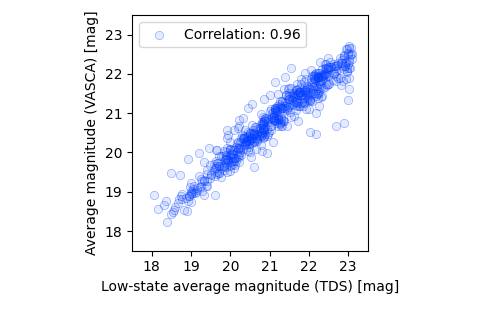

In [86]:
# Correlation of magnitude parameters
fig, ax = nb_fig("mag corr", gr_size=5, tight_layout=True)

# Pearson product-moment correlation
corr = np.corrcoef(tt_vasca_matched["match_mag_tds"], tt_vasca_matched["mag_mean"])[0, 1]

ax.scatter(
    tt_vasca_matched["match_mag_tds"],
    tt_vasca_matched["mag_mean"],
    lw=0.5,
    edgecolor=(*sns_bright_rgb[0], 0.4),
    facecolor=(*sns_bright_rgb[0], 0.1),
    label=f"Correlation: {corr:1.2f}"
)

mag_vmin = 17.5
mag_vmax = 23.5
ticks = np.arange(mag_vmin + 0.5, mag_vmax, 1)
ax.set_xlim((mag_vmin, mag_vmax))
ax.set_ylim((mag_vmin, mag_vmax))
ax.set_xticks(ticks)
ax.set_aspect(1)
ax.set_xlabel("Low-state average magnitude (TDS) [mag]")
ax.set_ylabel("Average magnitude (VASCA) [mag]")
ax.legend()

KeyError: 'mag_sig_int'

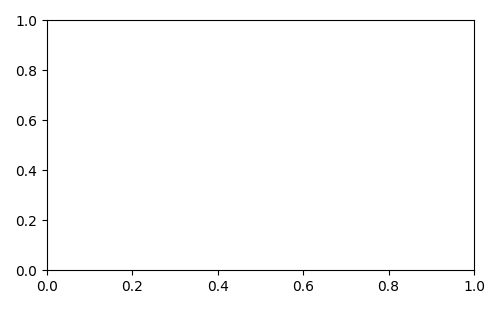

In [87]:
# Correlation of magnitude parameters: Intrinsic variability
fig, ax = nb_fig("mag sig int", gr_size=5, tight_layout=True)

# Pearson product-moment correlation
corr = np.corrcoef(tt_vasca_matched["match_sigint_tds"], tt_vasca_matched["mag_sig_int"])[0, 1]

ax.scatter(
    tt_vasca_matched["match_sigint_tds"],
    tt_vasca_matched["mag_sig_int"],
    lw=0.5,
    edgecolor=(*sns_bright_rgb[0], 0.4),
    facecolor=(*sns_bright_rgb[0], 0.1),
    label=f"Correlation: {corr:1.2f}"
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_aspect(1)
ax.set_xlabel("Intrinsic variability (TDS) [mag]")
ax.set_ylabel("Intrinsic variability (VASCA) [mag]")
ax.legend()

In [ ]:
# Average magnitude distribution
fig, ax = nb_fig(num="mag dist", gr_size=5, tight_layout=True)

bins = np.histogram_bin_edges(tt_tds["mlow"], bins="auto")

ax.hist(
    tt_tds["mlow"],
    bins=bins,
    histtype="stepfilled",
    lw=0.75,
    edgecolor=sns_bright_rgb[0],
    facecolor=(*sns_bright_rgb[0], 0.2),
    label=f"TDS (low-state), n={len(tt_tds['mlow'])}"
)
ax.hist(
    tt_vasca["mag_mean"],
    bins=bins,
    histtype="stepfilled",
    lw=0.75,
    edgecolor=sns_bright_rgb[1],
    facecolor=(*sns_bright_rgb[1], 0.2),
    label=f"VASCA, n={len(tt_vasca['mag_mean'])}"
)

ax.hist(
    tt_vasca_matched["match_mag_tds"],
    bins=bins,
    histtype="step",
    lw=1.2,
    edgecolor=sns_bright_rgb[0],
    facecolor=(*sns_bright_rgb[0], 0.2),
    hatch="//",
    label=f"TDS (low-state, matched), n={len(tt_vasca_matched['match_mag_tds'])}"
    
)
ax.hist(
    tt_vasca_matched["mag_mean"],
    bins=bins,
    histtype="step",
    lw=1.2,
    edgecolor=sns_bright_rgb[1],
    facecolor=(*sns_bright_rgb[1], 0.2),
    hatch="||",
    label=f"VASCA (matched), n={len(tt_vasca_matched['mag_mean'])}"
)

#ax.set_yscale("log")
ax.set_xlabel("Average magnitude [mag]")
ax.set_ylabel("Number of sources")
ax.legend(fontsize=8, loc="upper left")

#### Average magnitude distribution

In [ ]:
fig, axs = nb_fig(num="comb mag stats", figsize=(6.7, 3.0), ncols=2, constrained_layout=True)
fontsize = 8

ax = axs[0]
bins = np.histogram_bin_edges(tt_tds["mlow"], bins="auto")

ax.hist(
    tt_tds["mlow"],
    bins=bins,
    histtype="stepfilled",
    lw=0.75,
    edgecolor=sns_bright_rgb[0],
    facecolor=(*sns_bright_rgb[0], 0.2),
    label=f"TDS (low-state), n={len(tt_tds['mlow'])}"
)
ax.hist(
    tt_vasca["mag_mean"],
    bins=bins,
    histtype="stepfilled",
    lw=0.75,
    edgecolor=sns_bright_rgb[1],
    facecolor=(*sns_bright_rgb[1], 0.2),
    label=f"VASCA, n={len(tt_vasca['mag_mean'])}"
)

ax.hist(
    tt_vasca_matched["match_mag_tds"],
    bins=bins,
    histtype="step",
    lw=1.2,
    edgecolor=sns_bright_rgb[0],
    facecolor=(*sns_bright_rgb[0], 0.2),
    hatch="//",
    label=f"TDS (low-state, matched), n={len(tt_vasca_matched['match_mag_tds'])}"
    
)
ax.hist(
    tt_vasca_matched["mag_mean"],
    bins=bins,
    histtype="step",
    lw=1.2,
    edgecolor=sns_bright_rgb[1],
    facecolor=(*sns_bright_rgb[1], 0.2),
    hatch="||",
    label=f"VASCA (matched), n={len(tt_vasca_matched['mag_mean'])}"
)

#ax.set_yscale("log")
ax.set_xlabel("Average magnitude [mag]", fontsize=fontsize+2)
ax.set_ylabel("Number of sources", fontsize=fontsize+2)
ax.legend(fontsize=fontsize, loc="upper left")
ax.set_box_aspect(1)

ax = axs[1]
# Pearson product-moment correlation
corr = np.corrcoef(tt_vasca_matched["match_mag_tds"], tt_vasca_matched["mag_mean"])[0, 1]

ax.scatter(
    tt_vasca_matched["match_mag_tds"],
    tt_vasca_matched["mag_mean"],
    lw=0.5,
    edgecolor=(*sns_bright_rgb[0], 0.4),
    facecolor=(*sns_bright_rgb[0], 0.1),
    label=f"Avrg. magagnitude (matched)\nn={len(tt_vasca_matched)}, correlation: {corr:1.2f}"
)

mag_vmin = 17.5
mag_vmax = 23.5
ticks = np.arange(mag_vmin + 0.5, mag_vmax, 1)
ax.set_xlim((mag_vmin, mag_vmax))
ax.set_ylim((mag_vmin, mag_vmax))
ax.set_xticks(ticks)
ax.set_aspect(1)
ax.set_xlabel("TDS (low-state) [mag]", fontsize=fontsize+2)
ax.set_ylabel("VASCA [mag]", fontsize=fontsize+2)
ax.legend(fontsize=fontsize)

#### Intrinsic magnitude variability distribution

In [ ]:
fig, axs = nb_fig(num="comb mag sig int", figsize=(6.7, 3.0), ncols=2, constrained_layout=True)
fontsize = 8

ax = axs[0]
bins = np.histogram_bin_edges(tt_tds["sigint"], bins="auto")

ax.hist(
    tt_tds["sigint"],
    bins=bins,
    histtype="stepfilled",
    lw=0.75,
    edgecolor=sns_bright_rgb[0],
    facecolor=(*sns_bright_rgb[0], 0.2),
    label=f"TDS , n={len(tt_tds)}"
)
ax.hist(
    tt_vasca["mag_sig_int"],
    bins=bins,
    histtype="stepfilled",
    lw=0.75,
    edgecolor=sns_bright_rgb[1],
    facecolor=(*sns_bright_rgb[1], 0.2),
    label=f"VASCA, n={len(tt_vasca)}"
)

ax.hist(
    tt_vasca_matched["match_sigint_tds"],
    bins=bins,
    histtype="step",
    lw=1.2,
    edgecolor=sns_bright_rgb[0],
    facecolor=(*sns_bright_rgb[0], 0.2),
    hatch="//",
    label=f"TDS (matched), n={len(tt_vasca_matched)}"
    
)
ax.hist(
    tt_vasca_matched["mag_sig_int"],
    bins=bins,
    histtype="step",
    lw=1.2,
    edgecolor=sns_bright_rgb[1],
    facecolor=(*sns_bright_rgb[1], 0.2),
    hatch="||",
    label=f"VASCA (matched), n={len(tt_vasca_matched['mag_mean'])}"
)
ax.set_yscale("log")
ax.set_xlabel("Intrinsic variability [mag]", fontsize=fontsize+2)
ax.set_ylabel("Number of sources", fontsize=fontsize+2)
ax.legend(fontsize=fontsize, loc="upper right")
ax.set_box_aspect(1)

ax = axs[1]
# Pearson product-moment correlation
corr = np.corrcoef(tt_vasca_matched["match_sigint_tds"], tt_vasca_matched["mag_sig_int"])[0, 1]

ax.scatter(
    tt_vasca_matched["match_sigint_tds"],
    tt_vasca_matched["mag_sig_int"],
    lw=0.5,
    edgecolor=(*sns_bright_rgb[0], 0.4),
    facecolor=(*sns_bright_rgb[0], 0.1),
    label=f"Intrinsic variability (matched)\nn={len(tt_vasca_matched)}, correlation: {corr:1.2f}"
)

#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_box_aspect(1)
ax.set_xlabel("TDS [mag]", fontsize=fontsize)
ax.set_ylabel("VASCA [mag]", fontsize=fontsize)
ax.legend(fontsize=fontsize, loc="upper left")

#### Maximum delta magnitude amplitude distribution

In [ ]:
fig, axs = nb_fig(num="comb max dmag", figsize=(6.7, 3.0), ncols=2, constrained_layout=True)
fontsize = 8

ax = axs[0]
bins = np.histogram_bin_edges(tt_tds["Dmmax"], bins="auto")

ax.hist(
    tt_tds["Dmmax"],
    bins=bins,
    histtype="stepfilled",
    lw=0.75,
    edgecolor=sns_bright_rgb[0],
    facecolor=(*sns_bright_rgb[0], 0.2),
    label=f"TDS , n={len(tt_tds)}"
)
ax.hist(
    tt_vasca["mag_dmax"],
    bins=bins,
    histtype="stepfilled",
    lw=0.75,
    edgecolor=sns_bright_rgb[1],
    facecolor=(*sns_bright_rgb[1], 0.2),
    label=f"VASCA, n={len(tt_vasca)}"
)

ax.hist(
    tt_tds["Dmmax"][tt_vasca_matched["match_idx_tds"]],
    bins=bins,
    histtype="step",
    lw=1.2,
    edgecolor=sns_bright_rgb[0],
    facecolor=(*sns_bright_rgb[0], 0.2),
    hatch="//",
    label=f"TDS (matched), n={len(tt_tds['Dmmax'][tt_vasca_matched['match_idx_tds']])}"
    
)
ax.hist(
    tt_vasca_matched["mag_dmax"],
    bins=bins,
    histtype="step",
    lw=1.2,
    edgecolor=sns_bright_rgb[1],
    facecolor=(*sns_bright_rgb[1], 0.2),
    hatch="||",
    label=f"VASCA (matched), n={len(tt_vasca_matched['mag_mean'])}"
)
ax.set_yscale("log")
ax.set_xlabel("Maximum variability $|\\Delta m|_{{max}}$ [mag]", fontsize=fontsize+2)
ax.set_ylabel("Number of sources", fontsize=fontsize+2)
ax.legend(fontsize=fontsize-1, loc="upper right")
ax.set_box_aspect(1)

ax = axs[1]

# Pearson product-moment correlation
corr = np.corrcoef(tt_tds["Dmmax"][tt_vasca_matched["match_idx_tds"]], tt_vasca_matched["mag_dmax"])[0, 1]

ax.scatter(
    tt_tds["Dmmax"][tt_vasca_matched["match_idx_tds"]],
    tt_vasca_matched["mag_dmax"],
    lw=0.5,
    edgecolor=(*sns_bright_rgb[0], 0.4),
    facecolor=(*sns_bright_rgb[0], 0.1),
    label=f"Maximum variability (matched)\nn={len(tt_vasca_matched)}, correlation: {corr:1.2f}"
)

#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_box_aspect(1)
ax.set_xlabel("TDS [mag]", fontsize=fontsize)
ax.set_ylabel("VASCA [mag]", fontsize=fontsize)
ax.legend(fontsize=fontsize, loc="upper left")

#### Light curve skweness

In [ ]:
fig, ax = nb_fig(num="mag skew", tight_layout=True, gr_size=6)
bins = np.histogram_bin_edges(tt_vasca["mag_skew"], bins="auto")

normalize = False

ax.hist(
    tt_vasca["mag_skew"],
    bins=bins,
    histtype="step",
    density=normalize,
    color="k",
    label="VASCA (total)"
)
ax.hist(
    tt_vasca_matched["mag_skew"],
    bins=bins,
    histtype="step",
    density=normalize,
    color="k",
    lw=1.2,
    alpha=0.7,
    hatch="..",
    label="VASCA (matched)"
)
classes = ["Misc", "STAR", "Mdw", "RRL", "Point", "Galaxy", "Orphan", "QSO", "AGN", "?"]
class_list_list = [
    ["BHB", "CV", "RRAB", 'S Boo (LPV)'],
    ["STAR"],
    ["Mdw"],
    ["RRL"],
    ["Point Flare", "Point Trans", "Point Var"],
    ["Galaxy Flare", "Galaxy Trans"],
    ["Orphan Trans", "Orphan Var"],
    ["QSO"],
    ["AGN"],
    ["?"]
]

_, _, patches_cls = ax.hist(
    [df_vasca_matched.query("match_class_tds in @class_list")["mag_skew"] for class_list in class_list_list],
    bins=bins,
    histtype="stepfilled",
    density=normalize,
    stacked=True,
    lw=1.2,
    label=classes,
)
for i, patch in enumerate(patches_cls):
    patch[0].set_facecolor((*sns_bright_rgb[i], 0.4))
    patch[0].set_edgecolor(sns_bright_rgb[i])

ax.axvline(0,0,1,ls="-.", color="k",)
"""
class_list = ["RRL"]
ax.hist(
    df_vasca_matched.query("match_class_tds in @class_list")["mag_skew"],
    bins=bins
)
"""
#ax.set_yscale("log")
ax.legend(fontsize=8, ncol=2, loc="upper left")
ax.set_xlabel("Light curve skewness")
ax.set_ylabel("Number of sources")

#### Light curve type

In [ ]:
bar_data = dict()

lc_types = ["?", "Flare/Trans.", "Variable"]
classes = list(set(df_vasca_matched.match_class_tds))

bar_data["VASCA"] = {k: v for k,v in zip(lc_types, np.unique(df_vasca_matched.match_lc_tds, return_counts=True)[1])}
bar_data["TDS"] = {k: v for k,v in zip(lc_types, np.unique(tt_tds["LC"].data, return_counts=True)[1])}

df_bar_data = pd.DataFrame(bar_data).T
display(df_bar_data)

fig, ax = nb_fig(num="LC bar", tight_layout=True, gr_size=5)

n_srcs = [len(df_vasca_matched), len(tt_tds)]

df_bar_data.plot.bar(ax=ax, stacked=True, rot=45, color=[(*c, 0.8) for c in sns_bright_rgb[:3]], ylabel="Number of sources", xlabel="Catalog")
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    labels = [f"{l:1.0f} ({l/n_srcs[i] * 100:1.0f}%)" for i, l in enumerate(labels)]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center', fontsize=8)

#### Classification

In [ ]:
classes = sorted(["Galaxy", "Orphan", "Point", "STAR", "Mdw", "RRL", "QSO", "AGN", "?", "Misc"])
counts_vasca = dict.fromkeys(classes, 0)
counts_tds = dict.fromkeys(classes, 0)
for key in classes:
    if key == "Galaxy":
        classes_list = ["Galaxy Flare", "Galaxy Trans"]
    elif key == "Orphan":
        classes_list = ["Orphan Trans", "Orphan Var"]
    elif key == "Point":
        classes_list = ["Point Flare", "Point Trans", "Point Var"]
    elif key == "Misc":
        classes_list = ["BHB", "CV", "RRAB", 'S Boo (LPV)']
    else:
        classes_list = [key]
    
    counts_vasca[key] = len(df_vasca_matched.query("match_class_tds in @classes_list"))
    counts_tds[key] = len(df_tds.query("Class in @classes_list"))

bar_data["VASCA"] = counts_vasca
bar_data["TDS"] = counts_tds

df_bar_data = pd.DataFrame(bar_data).T
display(df_bar_data)

fig, ax = nb_fig(num="Class bar", tight_layout=True, figsize=(5,8))

n_srcs = [len(df_vasca_matched), len(tt_tds)]

df_bar_data.plot.bar(ax=ax, stacked=True, rot=45, color=[(*c, 0.8) for c in sns_bright_rgb[:10]], ylabel="Number of sources", xlabel="Catalog")
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else np.nan for v in c]
    labels = [f"{l:1.0f} ({l/n_srcs[i] * 100:1.0f}%)" for i, l in enumerate(labels)]
    labels = [l if not "nan" in l else "" for l in labels]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center', fontsize=6)

#### Nearest on-sky separation

In [ ]:
fig, ax = nb_fig(num="match distance", gr_size=5, tight_layout=True)

_, _, hpatch = ax.hist(
    tt_vasca_matched["match_dist_tds"].to("arcsec").data,
    bins="auto",
    cumulative=False,
    histtype="stepfilled",
    #alpha=0.5,
    edgecolor=sns_bright_rgb[0],
    facecolor=(*sns_bright_rgb[0], 0.4),
    lw=1,
    zorder=2,
    label=f"Sep. < {dist_lim.to('arcsec')}"
)
vline = ax.axvline(
    np.mean(np.asarray(tt_vasca["pos_err_se"].to("arcsec").data)),
    ls="--",
    lw=1.5,
    color="gray",
    label="VASCA average pos. error"
)
#ax.set_xlim((0,5))
ax.set_ylabel("Number of sources", fontsize=8)
ax.set_xlabel("On-sky distance [arcsec]")

ax = ax.twinx()
_, _, cpatch = ax.hist(
    tt_vasca_matched["match_dist_tds"].to("arcsec").data,
    bins="auto",
    cumulative=True,
    density=True,
    histtype="step",
    lw=1,
    color="k",
    zorder=1,
    label=f"Sep. < {dist_lim.to('arcsec')} (cum., norm.)"
)

ax.set_ylabel("No. o. sources (cummulative, normalized)", fontsize=8)
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.legend(handles=[vline, hpatch[0], cpatch[0]], fontsize=7, loc="center right")

## Search TDEs

In [ ]:
region_coords = SkyCoord.guess_from_table(rg.tt_sources["ra", "dec"], frame="icrs")

In [ ]:
# PS1-10jh
target_coord_ps1_10jh = SkyCoord(ra=242.36789, dec=53.67333, frame="icrs", unit=u.degree)
sel_sep_ps1_10jh = region_coords.separation(target_coord_ps1_10jh) < 5*u.arcsec
display(rg.tt_sources[sel_sep_ps1_10jh])

In [ ]:
# PS1-11af
target_coord_ps1_11af = SkyCoord(ra=149.36175, dec=3.23361, frame="icrs", unit=u.degree)
sel_sep_ps1_11af = region_coords.separation(target_coord_ps1_11af) < 5*u.arcsec
display(rg.tt_sources[sel_sep_ps1_11af])

In [ ]:
pos = {"ra":184.60462, "dec":46.61703} # PS1-13arp
pos = {"ra":214.8741, "dec":52.8684} # GALEX D3-13
target_coord_ps1_13arp = SkyCoord(**pos, frame="icrs", unit=u.degree)
sel_sep_ps1_13arp = region_coords.separation(target_coord_ps1_13arp) < 5*u.arcsec
display(rg.tt_sources[sel_sep_ps1_13arp])

In [ ]:

rg_src_ids = [
    rg.tt_sources[sel_sep_ps1_10jh]["rg_src_id"].data[0],
    rg.tt_sources[sel_sep_ps1_11af]["rg_src_id"].data[0]
]

In [ ]:
fig, ax = nb_fig(gr_size=5, tight_layout=True)
vvis.plot_light_curve(rg,rg_src_ids=rg_src_ids)